###Carga de datos y librerías necesarias

In [ ]:
#-- Descomprimimos el dataset e instalamos los paquetes necesarios
# !rm -r fashion-mnist
!unzip fashion-mnist.zip
!pip install hiddenlayer

In [2]:
#-- Importamos las librerías
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
from PIL import Image
import torch
from torch.autograd import Variable
import hiddenlayer as hl
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import torchvision.transforms as transforms

In [3]:
#-- Buscamos las direcciones de cada archivo de imagen
train_files = glob('./fashion-mnist/train/*/*.png')
valid_files = glob('./fashion-mnist/valid/*/*.png')
test_files = glob('./fashion-mnist/test/*/*.png') 

- Gracias a la gran cantidad de datos del dataset, únicamente utilizamos un 10% de estos (5500 de entrenamiento y 500 de testeo)

In [4]:
#-- Ordenamos los datos de forma aleatoria para evitar sesgos
np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

p = 0.1
train_files = train_files[:int(p*len(train_files))]
valid_files = valid_files[:int(p*len(valid_files))]
test_files = test_files[:int(p*len(test_files))]
len(train_files)

5500

####Debido a que la CNN que vamos a utilizar (AlexNet) recibe imágenes con un tamaño de (224,224,3), se hace necesario reescalar y normalizar las imágenes.

In [5]:
#-- Transformamos los datos para adaptarlos a la entrada de AlexNet 224x224 px
data_transform = transforms.Compose([
                 transforms.Resize((224, 224)),
                 transforms.Grayscale(3), #Dado que Fashion-mnist tiene un solo canal, lo cambiamos a 3.
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                 ])

In [6]:
#-- Cargamos los datos de entrenamiento en listas
N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append( np.array(data_transform(Image.open(train_file) )))

In [7]:
#-- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(data_transform(Image.open(test_file)) ))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


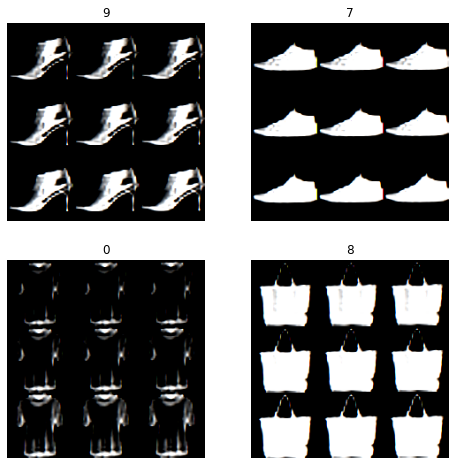

In [8]:
#-- Visualizamos los datos

fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15].reshape(224,224,3))
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [9]:
#-- Convetimos las listas con los datos a tensores de torch
X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([5500, 3, 224, 224])

In [10]:
#-- Creamos el DataLoader
batch_size = 32

train_ds = torch.utils.data.TensorDataset(X_train, Y_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

###Estructura de la CNN

Vamos a importar la CNN preentrenada AlexNet de torch. Utilizamos esta red debido a la gran validación que tiene a la hora de analizar las imágenes del set de ImageNet. Adicional a esto, AlexNet es una CNN relativamente simple, con pocas capas y siendo estas fácilmente modificables, lo cual nos facilita el proceso a la hora de cambiar la dimensión de la salida de la capa final.

In [11]:
model = torch.hub.load('pytorch/vision', 'alexnet', pretrained=True)
model

Using cache found in /root/.cache/torch/hub/pytorch_vision_master


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [12]:
#-- Congelamos los pesos en las capaz del modelo para que no se actualicen
for p in model.parameters():
    p.requires_grad = False

#-- Definimos el número de clases del dataset fashion-mnist
out_dim = 10

#-- Reescribimos la última capa con la salida del nuevo dataset
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5),  
    torch.nn.Linear(9216, 4096),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(4096, 4096),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(4096, out_dim)
)

model.load_state_dict(model.state_dict())

model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

####Pasamos ahora a entrenar nuestra AlexNet modificada con el dataset de fashion-mnist

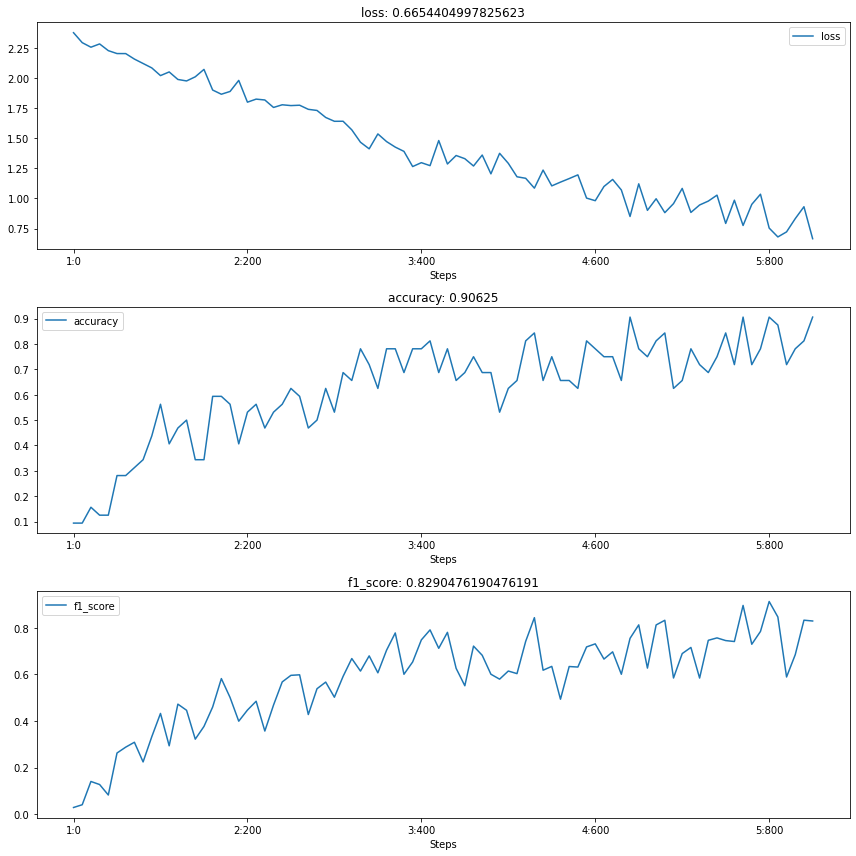

In [14]:
#-- Definimos nuestro criterio de evaluación y el optimizador 
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.1)
criterion = torch.nn.CrossEntropyLoss()


#-- Entrenamos el modelo usando únicamente 5 épocas
n_epochs = 5
model.train()

history = hl.History()
canvas = hl.Canvas()

iter = 0

for epoch in range(n_epochs):
  for batch_idx, (X_train_batch, Y_train_batch) in enumerate(train_dl):
    # Realiza una predicción
    Y_pred = model(X_train_batch)

    # Calcula el loss
    loss = criterion(Y_pred, Y_train_batch)

    Y_pred = torch.argmax(Y_pred, 1)
    f1 = f1_score(Y_train_batch, Y_pred, average='macro')

    # Calcula el accuracy
    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if iter%10 == 0:
        #-- Visualizamos la evolución de los score loss y accuracy
        history.log((epoch+1, iter), loss=loss, accuracy=acc, f1_score=f1)
        with canvas:
          canvas.draw_plot(history["loss"])
          canvas.draw_plot(history["accuracy"])
          canvas.draw_plot(history["f1_score"])

    iter += 1
    del X_train_batch, Y_train_batch, Y_pred


#### Visualizamos el mapa de características de la última capa convolucional

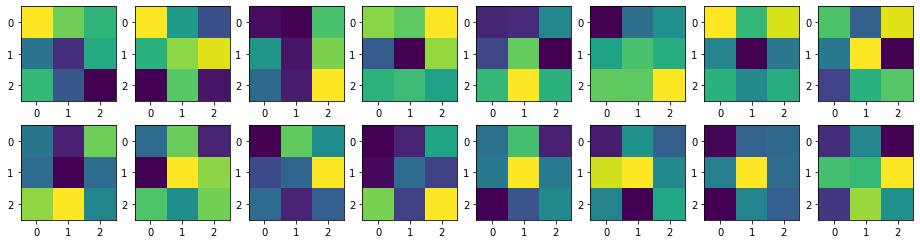

In [49]:
#-- Visualizando los primeros 16 mapas de características de la última capa convolucional (11ava capa)
kernels = list(model.children())[0][10].weight.detach()

fig = plt.figure(figsize=(16,4))
k = 0
for i in range(16):
    plt.subplot(2,8,k+1)
    plt.imshow(kernels[0][i].squeeze())
    k += 1
plt.show()

###Validación de la CNN entrenada y conclusiones

####Validamos ahora el modelo entrenado con el set de testeo.

In [16]:
#-- Validamos el modelo
model.eval()

Y_pred = model(X_test)
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print( 'Loss:{:.2f}, F1:{:.2f}, Acc:{:.2f}'.format(loss.item(), f1, acc ) )

Loss:0.71, F1:0.79, Acc:0.80


####Definimos la función de matrix de confusión y la generamos con los datos de testeo

In [17]:
def CM(Y_true, Y_pred, classes, lclasses=None):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  if lclasses == None:
    lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()

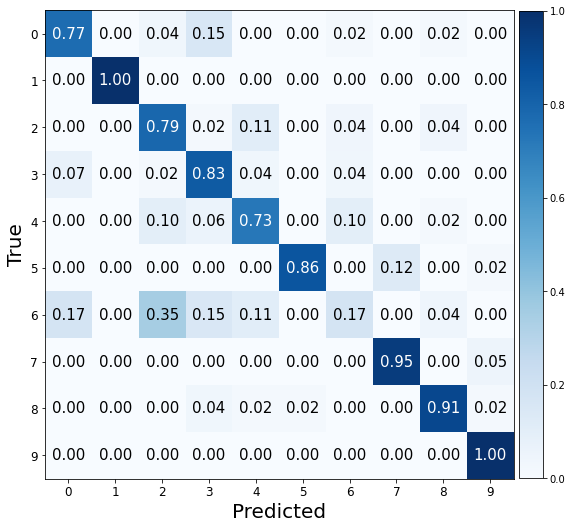

In [18]:
CM(Y_test, Y_pred, 10)

#### Análisis de la CNN y descripción de los resultados

##### Utilizamos AlexNet, una CNN de 2 capas secuenciales, y, entre ellas, una capa de Average Pool
- La primera capa secuencial contiene 5 capas convolucionales y 3 de MaxPool
- La segunda capa contiene 3 capas de Dropout y 3 lineales, en las cuales, la última de ellas, fue modificada para que su salida fuera de 10.

##### Obtuvimos unos valores del set de testeo de
- Loss = 0.71
- Accuracy = 0.80
- F1_score = 0.79


Finalmente y, debido a estos resultados, concluimos que nuestro entrenamiento no fue por completo exitoso. Sin embargo, si comparamos los parámetros con el ejercicio anterior en el que creábamos nuestra CNN desde 0, podemos ver una mejora en la eficiencia utilizando AlexNet, debido a que únicamente con la mitad de épocas (5) se pudo llegar a resultados, que, aunque peores, muy similares. 

Estos peores resultados también pudieron deberse al hecho de que debido al límite de memoria RAM, nuestra AlexNet únicamente pudo entrenarse con un 10% de los datos totales. 